In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec.node2vec import node2vec
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [173]:
G = nx.read_gml(".\\data\\datasets\\dblp.gml" )
print("# Nodes: ", len(G.nodes))
print("#Edges: ", len(G.edges))

# Nodes:  27199
#Edges:  66832


In [174]:
G.nodes['0']

{'community': 0}

In [188]:
def draw_graph(graph):
    fig = plt.figure(figsize=(30, 30))
    nodes = [i for i in range(len(graph.nodes)) if i%100 ==0]
    pos = nx.spring_layout(graph)
    labels = [graph.nodes[n]["community"] for n in graph.nodes if n in nodes]
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes, alpha=0.5, node_size=30, node_color=labels)
    nx.draw_networkx_edges(graph, pos, nodelist=nodes, alpha=0.5)
    plt.show()

In [189]:
draw_graph(G)


KeyboardInterrupt



<Figure size 2160x2160 with 0 Axes>

## Influence of the p and q parameters

In [158]:
l = [0.01, 0.1, 1, 10, 100]
pq = [(p, q) for p in l for q in l]

results = {}

for p, q in tqdm(pq):
    wv = node2vec(G, win_size=10, out_dim=200, n_walks=50, len_walk=50, p=p, q=q)
    repr_mat = wv.vectors
    index2word = wv.index2word
    X = repr_mat
    Y = np.array([G.nodes[word]["community"] for word in index2word])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6)
    
    model = LogisticRegression(penalty='l2', solver='lbfgs', multi_class="ovr")
    model.fit(X_train, Y_train)
    
    y_pred = model.predict(X_test)
    y_true = Y_test

    f1 = f1_score(y_true, y_pred, average="micro")
    cfm = confusion_matrix(y_true, y_pred)
    
    results[(p,q)] = (f1, cfm)

C:\Users\sbran\Anaconda3\envs\projet_recherche\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


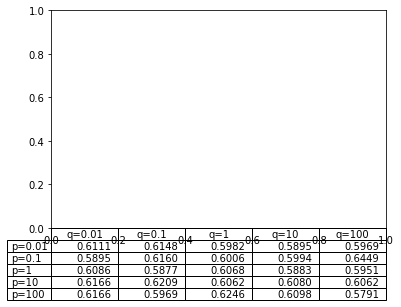

In [163]:
plt.table(cellText=[["{:.4f}".format(results[(p, q)][0]) for p in l] for q in l], 
          rowLabels=["p={}".format(p) for p in l], 
          colLabels=["q={}".format(q) for q in l])

## Influence of the core on random walks

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))
G = nx.k_core(G, 1)
core_numbers = nx.core_number(G)
print(np.unique(list(core_numbers.values())))

In [ ]:
nb_nodes = []
k_cores = np.unique(list(core_numbers.values()))

for k in k_cores:
    nb_nodes.append(len(nx.k_core(G, k))/len(G.nodes))

plt.bar(x=k_cores, height=nb_nodes)
plt.show()

In [156]:
from node2vec.node2vec import random_walk

rw = {}
rw_k = {}
for n in G.nodes:
    k_core = nx.core_number(G)[n]
    rw_k[n] = [random_walk(graph=G, node=n, len_walk=30, p=1, q=1) for _ in range(int(50*k_core/7))]
    rw[n] = [random_walk(graph=G, node=n, len_walk=30, p=1, q=1) for _ in range(50)]    

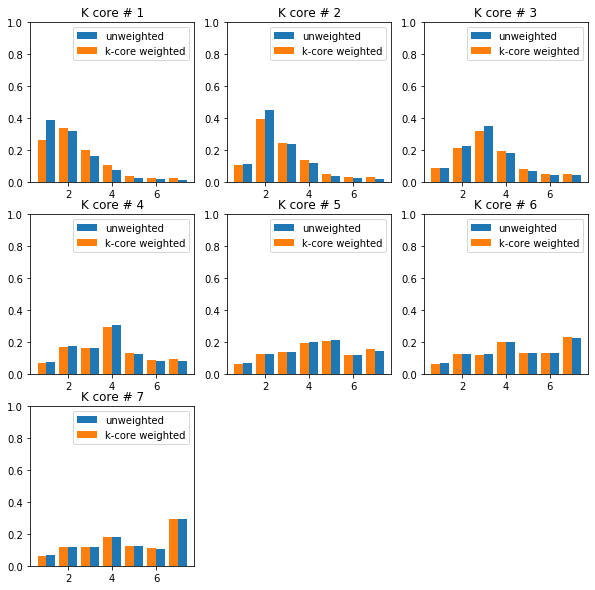

In [157]:
plt.figure(figsize=(10,10))
for k in np.unique(list(core_numbers.values())):
    props = {}
    c = 0

    for node in nx.k_core(G, k).nodes:
        for walk in rw[node]:
            for node in walk:
                if core_numbers[node] not in props:
                    props[core_numbers[node]] = 0
                props[core_numbers[node]] += 1
                c+=1

    for i in props:
        props[i] /= c

    #print("K core:", k)
    #print("proportions:", props)
    plt.subplot(3,3,k)
    plt.title("K core # {}".format(k))
    plt.ylim(0, 1)
    plt.bar(x=np.array(list(props.keys())) + 0.2, height=props.values(), 
            label="unweighted", width=0.4)
    c = 0
    
    for node in nx.k_core(G, k).nodes:
        for walk in rw_k[node]:
            for node in walk:
                if core_numbers[node] not in props:
                    props[core_numbers[node]] = 0
                props[core_numbers[node]] += 1
                c+=1

    for i in props:
        props[i] /= c
    plt.bar(x=np.array(list(props.keys())) - 0.2, height=props.values(), 
            label="k-core weighted", width=0.4)
    
    plt.legend()
plt.show()

In [158]:
walks_kcore = []
walks = []
for node_walks in rw_k.values():
    walks_kcore += node_walks
for node_walks in rw.values():
    walks += node_walks

In [159]:
print(len(walks), len(walks_kcore))

163200 40247


In [160]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score


In [161]:
def compute_f1(walks):
    model = Word2Vec(walks, size=100, window=5, min_count=0, sg=1, hs=1)
    wv = model.wv

    repr_mat = wv.vectors
    index2word = wv.index2word
    X = repr_mat
    Y = np.array([G.nodes[word]["community"] for word in index2word])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6)

    model = LogisticRegression(penalty='l2', solver="lbfgs", multi_class="ovr")
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_true = Y_test

    print("F1", f1_score(y_true, y_pred, average="micro"))

In [162]:
compute_f1(walks_kcore)

F1 0.5477284328739153


In [163]:
compute_f1(walks)

F1 0.5507912200102093


## Embedding & prediction

In [ ]:
wv = node2vec(G, win_size=5, out_dim=200, n_walks=50, len_walk=50, p=100, q=0.01)
repr_mat = wv.vectors
index2word = wv.index2word

In [ ]:
labels = np.unique([G.nodes[n]['community'] for n in G.nodes])

In [ ]:
X = repr_mat
Y = np.array([G.nodes[word]["community"] for word in index2word])

In [ ]:

model = LogisticRegression(penalty='l2')
model.fit(X_train, Y_train)

In [ ]:

y_pred = model.predict(X_test)
y_true = Y_test

print("F1", f1_score(y_true, y_pred, average="micro"))
confusion_matrix(y_true, y_pred)